# Qiskit 102: Building a Qiskit pattern workflow

## Step 1: Map classical problem to quantum circuits and observables

Este código implementa el QAOA para resolver el problema de Max-Cut en un grafo aleatorio. El algoritmo busca optimizar los parámetros beta y gamma del circuito cuántico para encontrar la mejor solución aproximada al problema.

In [19]:
import rustworkx as rx
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.circuit.library import RZZGate, RXGate

# Función para crear el Hamiltoniano de Max-Cut
def max_cut_hamiltonian(graph: rx.PyGraph) -> SparsePauliOp:
    # Inicializa una lista con el primer término de energía constante (proporcional al número de aristas)
    terms = [["", [], 0.5 * graph.num_edges()]]
    
    # Recorre cada arista del grafo y añade un término de tipo ZZ para el Hamiltoniano
    for edge in graph.edge_list():
        terms.append(["ZZ", edge, -0.5])
    
    # Devuelve el Hamiltoniano como un SparsePauliOp (una representación eficiente de operadores de Pauli)
    return SparsePauliOp.from_sparse_list(terms, num_qubits=graph.num_nodes())

# Función que construye el circuito cuántico QAOA
def qaoa_circuit(graph: rx.PyGraph, p: int) -> QuantumCircuit:
    # Crear listas de parámetros (betas y gammas) para cada capa del circuito
    betas = [Parameter(f"b_{i}") for i in range(p)]
    gammas = [Parameter(f"g_{i}") for i in range(p)]
    
    # Crear un registro cuántico con tantos qubits como nodos tenga el grafo
    qubits = QuantumRegister(graph.num_nodes())
    
    # Inicializar el circuito cuántico
    circuit = QuantumCircuit(qubits)
    
    # Aplicar una puerta Hadamard (H) a todos los qubits para crear una superposición inicial
    circuit.h(qubits)
    
    # Bucle que añade capas de QAOA, iterando sobre los parámetros beta y gamma
    for beta, gamma in zip(betas, gammas):
        # Aplicar la puerta RZZ entre cada par de qubits conectados por una arista en el grafo
        for (i, j) in graph.edge_list():
            circuit.append(RZZGate(gamma), [qubits[i], qubits[j]])
        
        # Aplicar la puerta RX (rotación alrededor de X) a cada qubit, utilizando el parámetro beta
        for q in qubits:
            circuit.append(RXGate(beta), [q])
    
    # Devuelve el circuito cuántico construido
    return circuit

# Parámetros del problema
n_qubits = 5            # Número de nodos (qubits) en el grafo
probability = 0.8       # Probabilidad de que exista una arista entre dos nodos
p = 1                   # Número de capas de QAOA (profundidad del circuito)

# Generar un grafo aleatorio no dirigido con n_qubits nodos y probabilidad de conexión
graph = rx.undirected_gnp_random_graph(num_nodes=n_qubits, probability=probability)

# Crear el Hamiltoniano de Max-Cut para el grafo generado
observable = max_cut_hamiltonian(graph)

# Construir el circuito cuántico de QAOA
circuit = qaoa_circuit(graph, p=p)

Representa el Hamiltoniano expresado mediante operadores Pauli. Cada término de la forma 'IIIII' o 'IIZIZ' es una combinación de operadores Pauli-I (identidad) y Pauli-Z (medición en el eje Z) aplicados sobre los qubits.

Las cadenas de caracteres ('IIZIZ', 'ZZIII', etc.) indican qué operadores se aplican a cada qubit.
Los coeficientes asociados (3.5, -0.5, etc.) representan la importancia o "peso" de cada término en la energía total.
En resumen:

El término constante 
3.5
3.5 corresponde al número de aristas en el grafo.
Los otros términos (
−
0.5
−0.5) penalizan las correlaciones entre qubits que están conectados por una arista, buscando minimizar la energía y, así, resolver el problema Max-Cut.

In [2]:
observable

SparsePauliOp(['IIIII', 'IIZIZ', 'IIZZI', 'IZIIZ', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

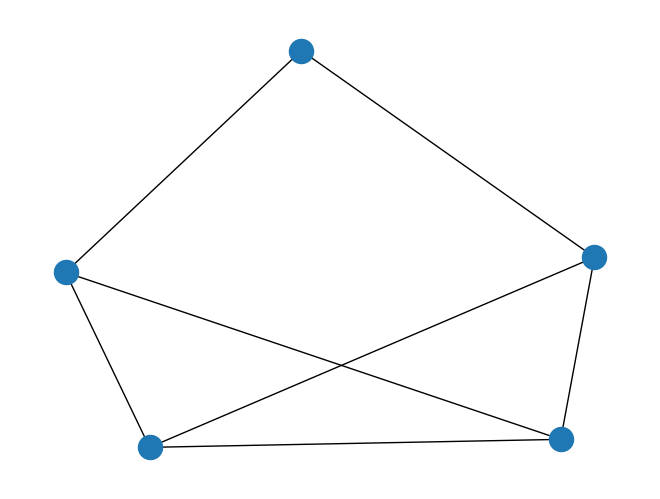

In [20]:
from rustworkx.visualization import mpl_draw

mpl_draw(graph)

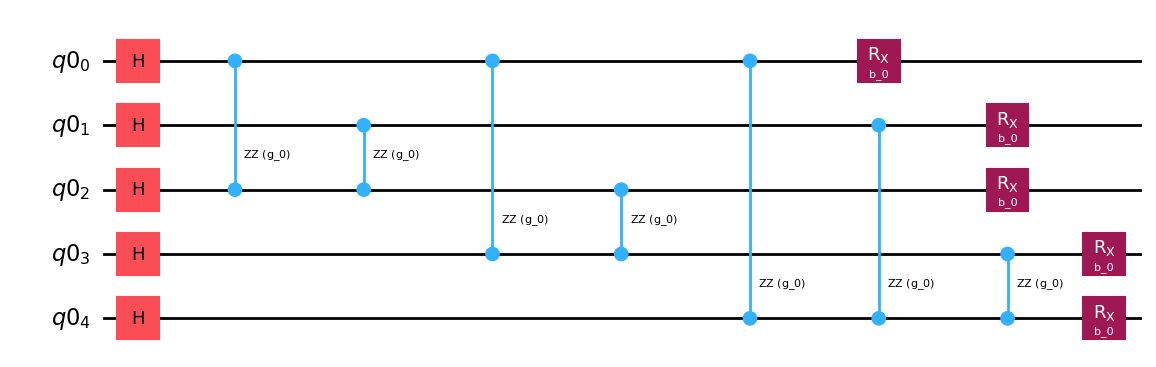

In [4]:
circuit.draw("mpl")

## Step 2: Optimize problem for execution on quantum hardware

Optimización del problema para su ejecución en un hardware cuántico 

* FakeSherbrooke: Simula un dispositivo cuántico.
* generate_preset_pass_manager: Genera un optimizador que adapta y mejora el circuito para ese backend simulado.
* pass_manager.run(circuit): Optimiza el circuito para su ejecución.
* apply_layout: Ajusta el observable a la disposición final de los qubits en el circuito optimizad

In [21]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeSherbrooke()

pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    # initial_layout=[0, 1, 2, 3, 4],
)

isa_circuit = pass_manager.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

In [6]:
observable

SparsePauliOp(['IIIII', 'IIZIZ', 'IIZZI', 'IZIIZ', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

In [7]:
isa_observable

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZZIIIIIIIIIIIIIIIIIIIIIIIIII

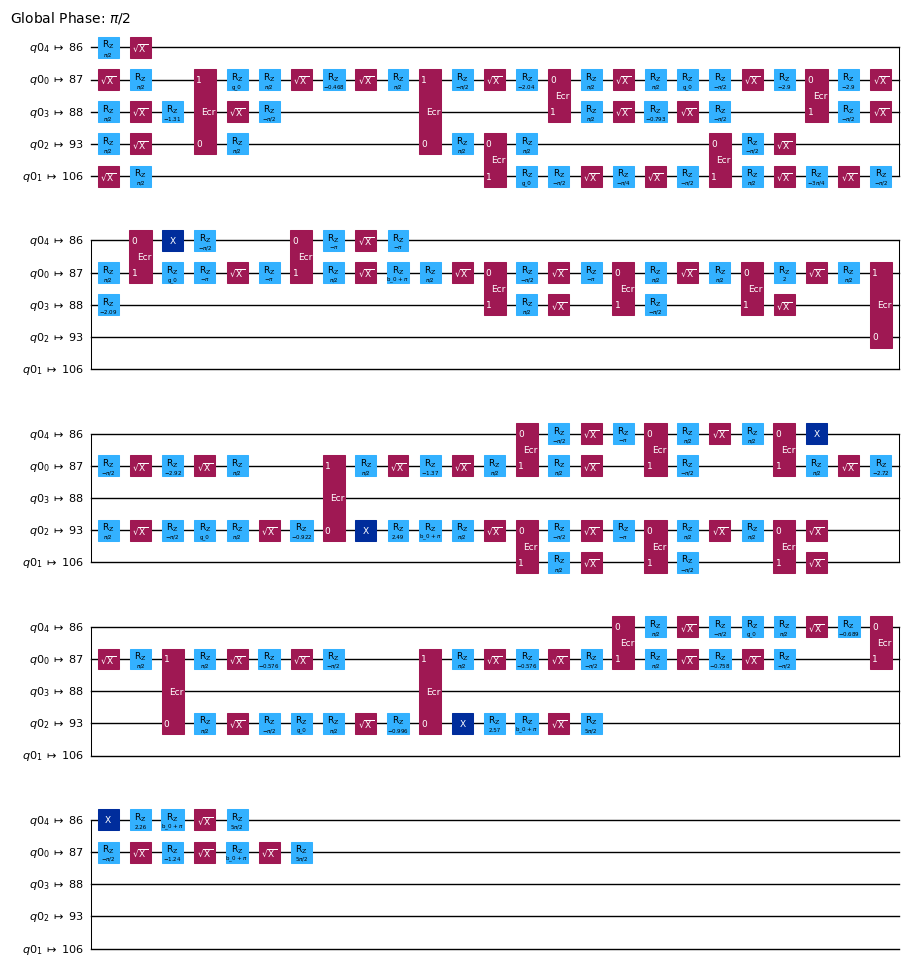

In [8]:
isa_circuit.draw("mpl", idle_wires=False, scale=0.5)

In [23]:
# from qiskit.visualization import plot_circuit_layout

# plot_circuit_layout(isa_circuit, backend)

In [10]:
# from qiskit.visualization import plot_error_map

# plot_error_map(backend, figsize=(20, 20))

## Step 3: Execute circuits using Qiskit Primitives

In [25]:
# Importar la clase EstimatorV2 de Qiskit para estimar observables en circuitos cuánticos
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np  # Importar NumPy para operaciones numéricas

# Inicializar un generador de números aleatorios
rng = np.random.default_rng()

# Generar parámetros aleatorios en el rango [-π, π] para el circuito cuántico
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Crear un objeto Estimator que se conectará al backend especificado
estimator = Estimator(mode=backend)

# Agrupar el circuito cuántico, el observable y los parámetros en una tupla
pub = (isa_circuit, isa_observable, params)

# Ejecutar el estimador usando la tupla 'pub' para obtener resultados de la estimación
job = estimator.run([pub])


In [12]:
# Obtener el resultado del trabajo de estimación ejecutado en el backend
result = job.result()

# Extraer el primer resultado de la lista de resultados
pub_result = result[0]

# Obtener el valor esperado (expectation value) del resultado y convertirlo a float
expectation_val = float(pub_result.data.evs)

# Mostrar el valor esperado
expectation_val


3.5068359375

In [26]:
from qiskit_ibm_runtime import Session
import scipy.optimize

# Definición de la función objetivo f(x) que será optimizada
# x son los parámetros del circuito que estamos ajustando
def f(x: np.ndarray, estimator: Estimator) -> float:
    # Crear la publicación con el circuito, el observable y los parámetros actuales
    pub = (isa_circuit, isa_observable, x)
    
    # Ejecutar el trabajo cuántico usando el Estimator y obtener el resultado
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    
    # Obtener el valor esperado (expectation value) del observable y negarlo para minimizar
    val = -float(pub_result.data.evs)
    
    # Imprimir el valor de la función objetivo para seguimiento
    print(f"Objective function value: {val}")
    
    # Devolver el valor negado de la expectativa (para la optimización)
    return val

# Crear una sesión con el backend (simulado o real)
with Session(backend=backend):
    # Inicializar el Estimator en el backend cuántico
    estimator = Estimator(mode=backend)
    
    # Ejecutar la optimización usando el método COBYLA, que es adecuado para funciones no derivables
    # 'params' son los parámetros iniciales del circuito, y se pasan a f(x) junto con el Estimator
    result = scipy.optimize.minimize(
        f, params, args=(estimator,), method="COBYLA", options=dict(maxiter=5)  # Ejecutar por 5 iteraciones
    )


Objective function value: -3.4521484375
Objective function value: -3.531982421875
Objective function value: -3.69091796875
Objective function value: -3.962890625
Objective function value: -3.299560546875


In [14]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# params = result.x  # Aquí se pueden utilizar los parámetros optimizados obtenidos previamente

# Inicializar el Sampler en el backend cuántico
sampler = Sampler(mode=backend)

# Crear una copia del circuito original y agregarle las mediciones
circuit_with_meas = circuit.copy()
circuit_with_meas.measure_all()  # Añadir mediciones a todas las qubits

# Transpilar el circuito para que se ajuste al backend especificado
isa_circuit = pass_manager.run(circuit_with_meas)

# Crear el conjunto de datos (publicación) para ejecutar: circuito transpilar y parámetros
pub = (isa_circuit, params)

# Ejecutar el trabajo cuántico con el Sampler, que generará distribuciones de probabilidad de mediciones
job = sampler.run([pub])

# Obtener el resultado de la ejecución
result = job.result()

# Extraer los resultados específicos para el trabajo publicado
pub_result = result[0]

# Mostrar el resultado
pub_result


SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=5>)), metadata={'shots': 1024, 'circuit_metadata': {}})

## Step 4: Postprocess results into classical format
El objetivo es tomar los resultados cuánticos obtenidos en el paso anterior (que suelen ser probabilidades o frecuencias de medición de los qubits) y convertirlos en un formato útil para su interpretación en un contexto clásico.

In [28]:
# Extraer los conteos de los resultados de la medición
# pub_result.data.meas.get_counts() devuelve un diccionario donde las claves son los bitstrings
# (las cadenas de bits obtenidas tras la medición del circuito cuántico) y los valores son las veces
# que ese bitstring específico fue medido.
counts = pub_result.data.meas.get_counts()

# Encontrar el bitstring más frecuente
# Esta línea recorre el diccionario counts y selecciona el bitstring (clave) que tiene el mayor número de ocurrencias (valor).
# La función lambda x: counts[x] devuelve el número de ocurrencias de cada bitstring, y la función max() selecciona el mayor.
bitstring = max(counts, key=lambda x: counts[x])


In [ ]:
observable

SparsePauliOp(['IIIII', 'IIZIZ', 'IIZZI', 'IZIIZ', 'IZZII', 'ZIIIZ', 'ZIIZI', 'ZZIII'],
              coeffs=[ 3.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j, -0.5+0.j,
 -0.5+0.j])

In [16]:
# Definir la función cut_size que toma un bitstring y un grafo como entrada.
# Devuelve un entero que representa el tamaño del corte en el grafo.
def cut_size(bitstring: str, graph: rx.PyGraph) -> int:
    # La función recorre todas las aristas del grafo (graph.edge_list())
    # y cuenta cuántas veces los nodos conectados por esa arista tienen valores diferentes en el bitstring.
    # Esto indica que la arista está "cortada" entre dos nodos en diferentes subconjuntos.
    return sum(bitstring[-i-1] != bitstring[-j-1] for i, j in graph.edge_list())

# Llamar a la función cut_size pasando el bitstring obtenido previamente y el grafo original.
cut_value = cut_size(bitstring, graph)


2

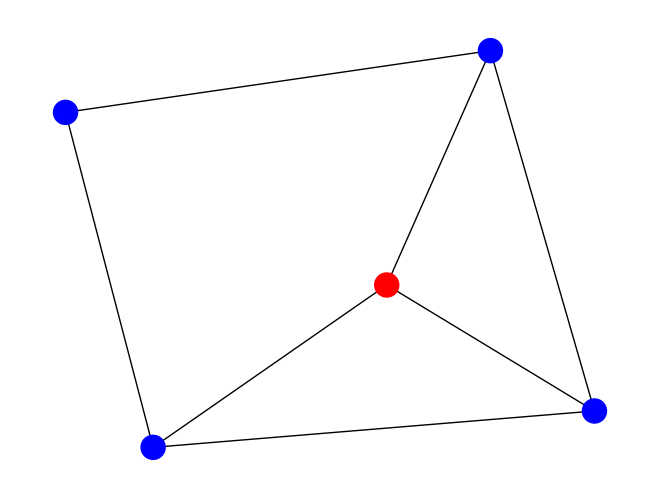

In [17]:
colors = ["red" if b == "0" else "blue" for b in bitstring]

mpl_draw(graph, node_color=colors)

In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='0a915001bd177a4a1cf4474cdecf396913008a88def78d863c8e500d9eeaa33e27e7b65b6f8a84aa2b69f98b18f07593c4fdb7409fb9e4ae36e1786eb956cbb8'
)

# Or save your credentials on disk.
# QiskitRuntimeService.save_account(channel='ibm_quantum', instance='ibm-q/open/main', token='0a915001bd177a4a1cf4474cdecf396913008a88def78d863c8e500d9eeaa33e27e7b65b6f8a84aa2b69f98b18f07593c4fdb7409fb9e4ae36e1786eb956cbb8')

b = service.backends()[0]